In [1]:
from conex import *
import torch
from pymonntorch import *

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
class PoissionGenerator(Behavior) :

    def initialize(self, ng) : 
        self.offset = ng.network.iteration
        self.T = self.parameter("T", 50)
        self.lamda = self.parameter("lamda", 20)
        self.target = self.parameter("target", required = True)
        self.poisson = 0

    def forward(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            ng.spikes[self.target] = torch.rand(len(self.target)) < 0
        else :
            self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)
            ng.spikes[self.target] = torch.rand(len(self.target)) <= self.poisson

    def pattern(self, ng) : 
        if(ng.network.iteration - self.offset > self.T) : 
            return -1   
        return 1

In [46]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 2, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 8,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k = 1),
    ActivityBaseHomeostasis(
        window_size = 50,
        activity_rate = 4,
        updating_rate = 1.1
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
    
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 1.2,
        a_minus = 1,
    ),
    # WeightNormalization(norm = 50)
]) | ({
    800 : Recorder(["I", "weights"]),
}))

weights = torch.Tensor([1, 0, 1])
weight_shape = (1, 1, 1, 1, 3)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 25)
])| ({
    800 : Recorder(["I"]),
}))

In [47]:
net.initialize()

for i in range(10) : 
    if(i < 5) : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

# Resting phase
net.simulate_iterations(200)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(4) : 
    if i < 2 : 
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]))
    else :
        ng1.add_behavior(341, PoissionGenerator(T = 50, lamda = 20, target = [5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

Network['Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(24)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal

C:\Users\Asus\AppData\Local\Temp\ipykernel_108\1415618111.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 431.473ms
100xBatch: 1/1 (100%) 383.753ms
100xBatch: 1/1 (100%) 447.014ms
100xBatch: 1/1 (100%) 371.235ms
100xBatch: 1/1 (100%) 395.452ms
100xBatch: 1/1 (100%) 436.448ms
100xBatch: 1/1 (100%) 454.558ms
100xBatch: 1/1 (100%) 449.617ms
100xBatch: 1/1 (100%) 356.336ms
100xBatch: 1/1 (100%) 362.298ms
200xBatch: 1/1 (100%) 756.406ms
100xBatch: 1/1 (100%) 333.348ms
100xBatch: 1/1 (100%) 374.176ms
100xBatch: 1/1 (100%) 495.471ms
100xBatch: 1/1 (100%) 434.594ms


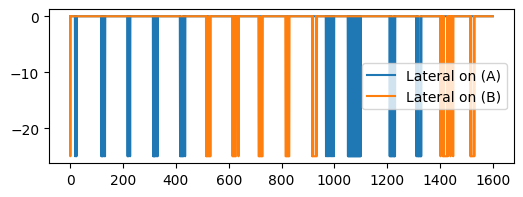

In [48]:
plt.figure(figsize = (6, 2))
plt.plot(sg_lateral['I', 0])
plt.legend(["Lateral on (A)", "Lateral on (B)"])
plt.show()

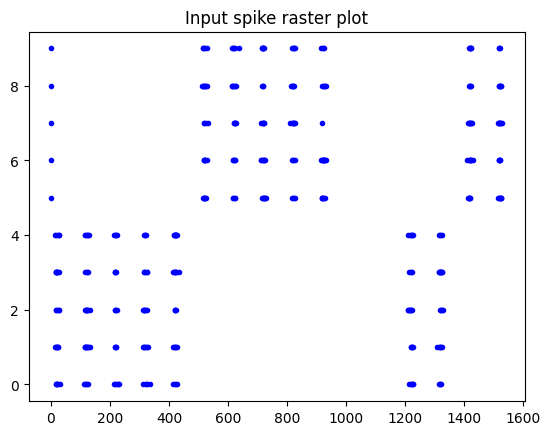

In [56]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.title("Input spike raster plot")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_108\2345668160.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


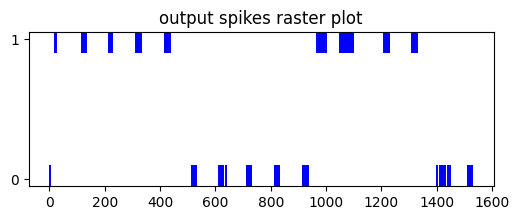

In [55]:
plt.figure(figsize = (6, 2))
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([0, 1])
plt.show()

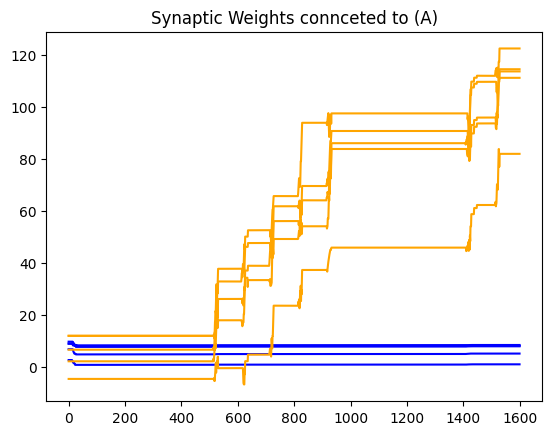

In [51]:
A = sg['weights', 0][:,:,0]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (A)")
plt.show()

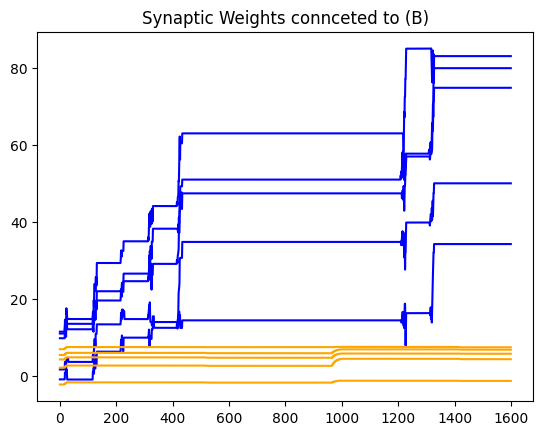

In [52]:
A = sg['weights', 0][:,:,1]
plt.plot(A[:,:5], color = "blue")
plt.plot(A[:,5:], color = "orange")
plt.title("Synaptic Weights connceted to (B)")
# # plt.legend(["neuron{} -> A".format(i + 1) for i in range(10)])
plt.show()

# K-patterns

In [889]:
class WeightDecay(Behavior) :

    def initialize(self, sg) : 
        self.decay_rate = self.parameter("decay_rate", 0.99)

    def forward(self, sg) : 
        sg.weights *= self.decay_rate

## Config

In [23]:
K = 5 # -> number of patterns
N = 5 # -> number of input-layers per pattern

In [906]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = N * K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 1,
        R = 6,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k = 1),
    ActivityBaseHomeostasis(
        window_size = 4000,
        activity_rate = 10,
        updating_rate = 1.2,
        decay_rate = 0.67
    ),
    Fire(),
    SpikeTrace(tau_s = 8),
    NeuronAxon(),
    
]) | ({
    800 : Recorder(["I"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 6)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    # WeightNormalization(norm = 50),
    WeightClip(w_max = 25, w_min = 0),
]) | ({
    # 439 : WeightDecay(decay_rate = 0.999999),
    800 : Recorder(["I", "weights"]),
}))

weights = torch.Tensor([1] * (K - 1) + [0] + [1] * (K - 1))
weight_shape = (1, 1, 1, 1, 2*K - 1)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 30)
])| ({
    800 : Recorder(["I"]),
}))

In [907]:
net.initialize()

for i in range(K) : 
    for _ in range(5) : 
        ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
        net.simulate_iterations(100)
        ng1.remove_behavior(342)

# Resting phase
sg.remove_behavior(439)
net.simulate_iterations(500)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(K) : 
    ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
    net.simulate_iterations(100)
    ng1.remove_behavior(342)

Network['Network'](Neurons: tensor(60)|2 groups, Synapses: tensor(600)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](50){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proxim

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\1415618111.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 684.681ms
100xBatch: 1/1 (100%) 324.133ms
100xBatch: 1/1 (100%) 361.033ms
100xBatch: 1/1 (100%) 316.155ms
100xBatch: 1/1 (100%) 280.249ms
100xBatch: 1/1 (100%) 312.163ms
100xBatch: 1/1 (100%) 297.206ms
100xBatch: 1/1 (100%) 306.182ms
100xBatch: 1/1 (100%) 381.979ms
100xBatch: 1/1 (100%) 382.975ms
100xBatch: 1/1 (100%) 358.004ms
100xBatch: 1/1 (100%) 346.112ms
100xBatch: 1/1 (100%) 361.990ms
100xBatch: 1/1 (100%) 362.032ms
100xBatch: 1/1 (100%) 386.965ms
100xBatch: 1/1 (100%) 411.898ms
100xBatch: 1/1 (100%) 405.955ms
100xBatch: 1/1 (100%) 365.983ms
100xBatch: 1/1 (100%) 409.930ms
100xBatch: 1/1 (100%) 405.894ms
100xBatch: 1/1 (100%) 429.846ms
100xBatch: 1/1 (100%) 453.786ms
100xBatch: 1/1 (100%) 449.796ms
100xBatch: 1/1 (100%) 492.683ms
100xBatch: 1/1 (100%) 546.537ms
100xBatch: 1/1 (100%) 563.494ms
100xBatch: 1/1 (100%) 482.711ms
100xBatch: 1/1 (100%) 571.472ms
100xBatch: 1/1 (100%) 557.508ms
100xBatch: 1/1 (100%) 542.550ms
100xBatch: 1/1 (100%) 527.593ms
100xBatc

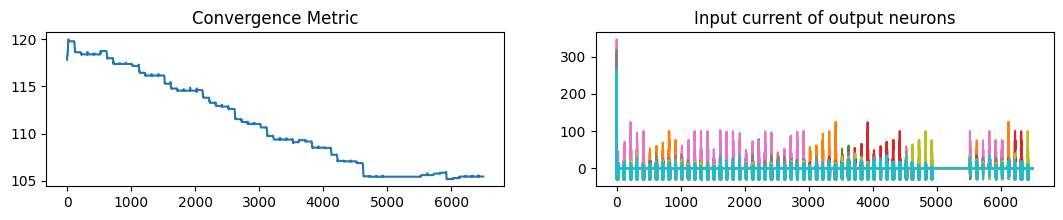

In [908]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, K, 0, 25)/25 * 15) 
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0])
plt.title("Input current of output neurons")

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\4068010010.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)


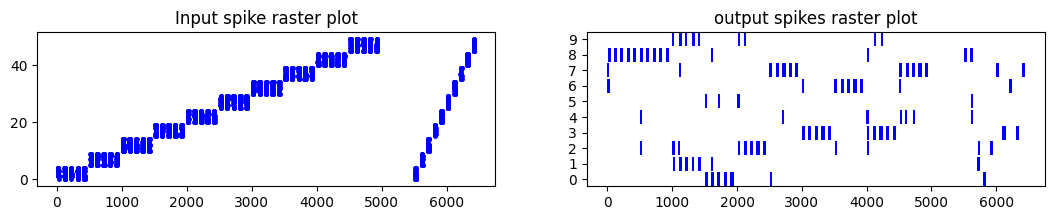

In [900]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(ng1['spikes.t', 0][N*K:], ng1['spikes.i', 0][N*K:], '.', color = "blue", markersize = 5)
plt.title("Input spike raster plot")

plt.subplot(1, 2, 2)
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([i for i in range(K)])

plt.show()

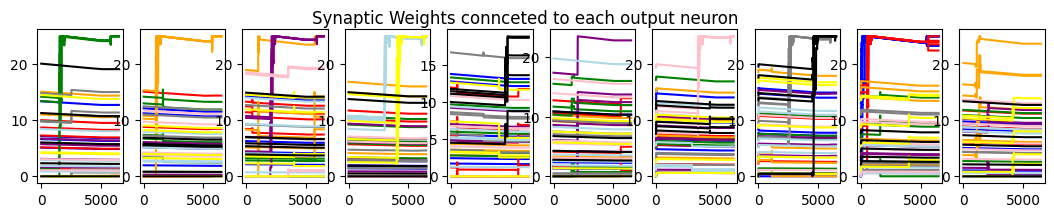

In [901]:
plt.figure(figsize = (13, 2))
colors = ['blue', 'red', 'orange', 'green', 'purple', "gray", "lightblue", "pink", "yellow", "black"]
for i in range(K) : 
    A = sg['weights', 0][:,:,i]
    for j in range(K) : 
        plt.subplot(1, K, i + 1)
        plt.plot(A[:,(j*N):(j + 1)*N], color = colors[j], label = f"pattern {j + 1}")
    # plt.legend()
plt.suptitle(f"Synaptic Weights connceted to each output neuron")
plt.show()    

# Higher-level patterns

### Config

In [966]:
K = 20 # -> number of patterns
N = 5 # -> number of input-layers per pattern

In [968]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = N * K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 1,
        R = 6,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k = 1),
    ActivityBaseHomeostasis(
        window_size = 300,
        activity_rate = 10,
        updating_rate = 0.8,
        decay_rate = 0.8
    ),
    Fire(),
    SpikeTrace(tau_s = 8),
    NeuronAxon(),
    
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 6)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    WeightNormalization(norm = 70),
    WeightClip(w_max = 25, w_min = 0),
]) | ({
    800 : Recorder(["I", "weights"]),
}))

weights = torch.Tensor([1] * (K - 1) + [0] + [1] * (K - 1)) * 0.5
weight_shape = (1, 1, 1, 1, 2*K - 1)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 25)
])| ({
    800 : Recorder(["I"]),
}))

In [969]:
net.initialize()

for i in range(K) : 
    for _ in range(3) : 
        ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
        net.simulate_iterations(100)
        ng1.remove_behavior(342)

# sg.remove_behavior(439)
# Resting phase
net.simulate_iterations(500)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(K) : 
    ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
    net.simulate_iterations(100)
    ng1.remove_behavior(342)

Network['Network'](Neurons: tensor(120)|2 groups, Synapses: tensor(2400)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](100){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](20){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,pro

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\1415618111.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 874.624ms
100xBatch: 1/1 (100%) 419.873ms
100xBatch: 1/1 (100%) 400.927ms
100xBatch: 1/1 (100%) 336.101ms
100xBatch: 1/1 (100%) 495.698ms
100xBatch: 1/1 (100%) 532.579ms
100xBatch: 1/1 (100%) 527.588ms
100xBatch: 1/1 (100%) 443.815ms
100xBatch: 1/1 (100%) 485.702ms
100xBatch: 1/1 (100%) 427.854ms
100xBatch: 1/1 (100%) 524.594ms
100xBatch: 1/1 (100%) 591.419ms
100xBatch: 1/1 (100%) 570.473ms
100xBatch: 1/1 (100%) 603.390ms
100xBatch: 1/1 (100%) 603.381ms
100xBatch: 1/1 (100%) 643.282ms
100xBatch: 1/1 (100%) 665.221ms
100xBatch: 1/1 (100%) 662.229ms
100xBatch: 1/1 (100%) 725.069ms
100xBatch: 1/1 (100%) 743.012ms
100xBatch: 1/1 (100%) 750.003ms
100xBatch: 1/1 (100%) 801.848ms
100xBatch: 1/1 (100%) 774.930ms
100xBatch: 1/1 (100%) 782.904ms
100xBatch: 1/1 (100%) 845.740ms
100xBatch: 1/1 (100%) 818.811ms
100xBatch: 1/1 (100%) 874.660ms
100xBatch: 1/1 (100%) 901.590ms
100xBatch: 1/1 (100%) 925.526ms
100xBatch: 1/1 (100%) 949.465ms
100xBatch: 1/1 (100%) 970.401ms
100xBatc

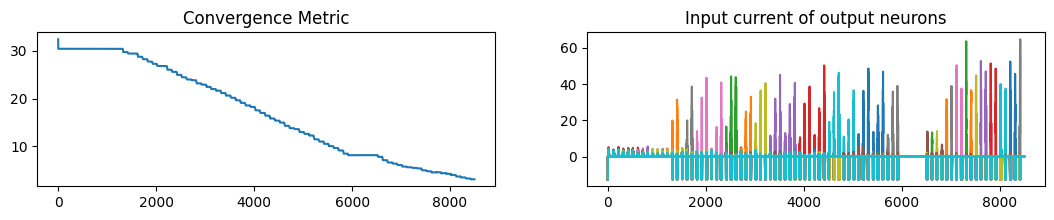

In [970]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, K, W_max = 12))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0][2:])
plt.title("Input current of output neurons")

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\476093100.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)


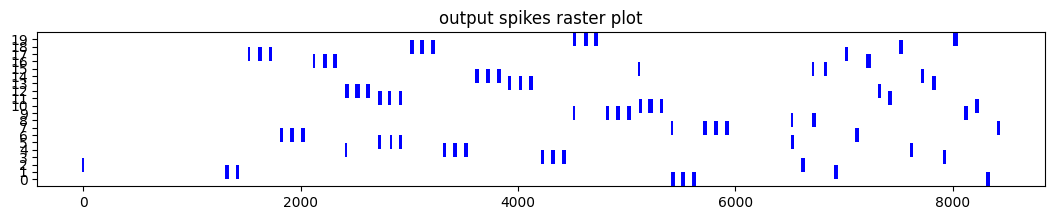

In [976]:
plt.figure(figsize = (13, 2))

plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 10, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([i for i in range(K)])

plt.show()

In [984]:
A = sg['weights', 0][:,:,0]
j = 1

torch.Size([8500])

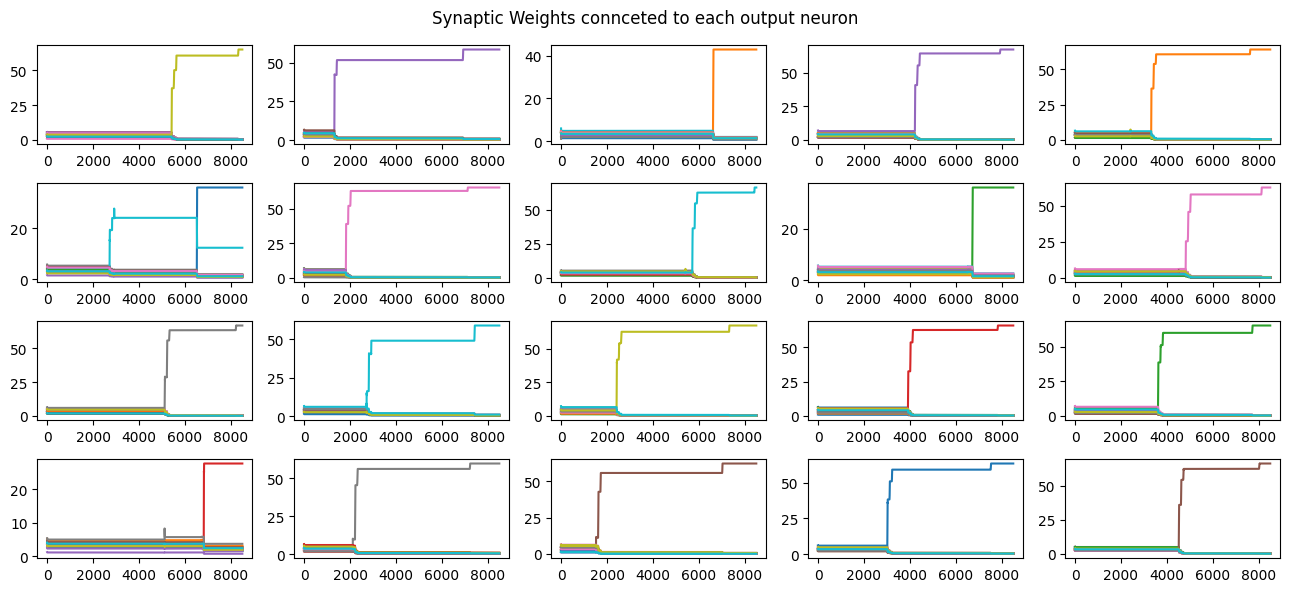

In [985]:
plt.figure(figsize = (13, 6))
colors = ['blue', 'red', 'orange', 'green', 'purple', "gray", "lightblue", "pink", "yellow", "black"]
for i in range(K) : 
    A = sg['weights', 0][:,:,i]
    for j in range(K) : 
        plt.subplot(4, 5, i + 1)
        plt.plot(torch.sum(A[:,(j*N):(j + 1)*N], axis = 1), label = f"pattern {j + 1}")
    # plt.legend()
plt.suptitle(f"Synaptic Weights connceted to each output neuron")
plt.tight_layout()
plt.show()    

# Voltage-based Homeostasis

### Config

In [312]:
K = 5 # -> number of patterns
N = 5 # -> number of input-layers per pattern

In [860]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = N * K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 50, lamda = 20, target = [0, 1, 2, 3, 4]),
    800 : Recorder(["I"]),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = K, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    AELIF(
        tau = 1,
        R = 2,
        threshold = 10,
        v_rest = -65,
        v_reset = -70,
        delta = 3,
        theta_rh = -13,
        alpha = 0.2,
        beta = 2,
        w_tau = 10
    ),
    KWTA(k = 1),
    ActivityBaseHomeostasis(
        window_size = 500,
        activity_rate = 15,
        updating_rate = 0.8,
        decay_rate = 0.8
    ),
    VoltageBaseHomeostasis(
        target_voltage = -35,
        max_ta = -20,
        min_ta = -40,
        eta_ip = 0.0003
    ),
    Fire(),
    SpikeTrace(tau_s = 8),
    NeuronAxon(),
    
]) | ({
    800 : Recorder(["I"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(7, 2)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 20,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    # WeightNormalization(norm = 50),
    WeightClip(w_max = 20, w_min = 0),
]) | ({
    800 : Recorder(["weights"]),
}))

weights = torch.Tensor([1] * (K - 1) + [0] + [1] * (K - 1))
weight_shape = (1, 1, 1, 1, 2*K - 1)
weights = weights.view(weight_shape)


sg_lateral = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal, inh", behavior= prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights = weights, weight_shape = weight_shape),
    LateralDendriticInput(inhibitory = True, current_coef = 12.5)
]))

In [861]:
net.initialize()

epoch = 0
MAX_EPOCH = 1
while(True) : 
    for i in range(K) : 
        for _ in range(5) : 
            ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
            net.simulate_iterations(100)
            ng1.remove_behavior(342)
    
    epoch += 1
    conv_rate = convergence_metric(sg, K, W_max = 20)[-1]
    print(f"epoch : {epoch}, convergence metric : {conv_rate}")
    if(conv_rate < 10 or epoch >= MAX_EPOCH) : 
        break

ng2.remove_behavior(301)
# Resting phase
net.simulate_iterations(500)

# test-phase
ng2.remove_behavior(400) # Remove STDP
for i in range(K) : 
    ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20, target = [j for j in range(N*i, N*(i + 1))]))
    net.simulate_iterations(100)
    ng1.remove_behavior(342)

Network['Network'](Neurons: tensor(30)|2 groups, Synapses: tensor(150)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](25){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['I'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](5){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\1415618111.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 335.102ms
100xBatch: 1/1 (100%) 298.227ms
100xBatch: 1/1 (100%) 280.224ms
100xBatch: 1/1 (100%) 296.210ms
100xBatch: 1/1 (100%) 321.142ms
100xBatch: 1/1 (100%) 344.079ms
100xBatch: 1/1 (100%) 362.034ms
100xBatch: 1/1 (100%) 334.106ms
100xBatch: 1/1 (100%) 343.082ms
100xBatch: 1/1 (100%) 305.186ms
100xBatch: 1/1 (100%) 311.156ms
100xBatch: 1/1 (100%) 296.207ms
100xBatch: 1/1 (100%) 317.152ms
100xBatch: 1/1 (100%) 296.208ms
100xBatch: 1/1 (100%) 391.954ms
100xBatch: 1/1 (100%) 376.988ms
100xBatch: 1/1 (100%) 365.025ms
100xBatch: 1/1 (100%) 398.933ms
100xBatch: 1/1 (100%) 411.898ms
100xBatch: 1/1 (100%) 349.067ms
100xBatch: 1/1 (100%) 337.100ms
100xBatch: 1/1 (100%) 404.916ms
100xBatch: 1/1 (100%) 400.929ms
100xBatch: 1/1 (100%) 336.101ms
100xBatch: 1/1 (100%) 317.151ms
epoch : 1, convergence metric : 66.85179138183594
500xBatch: 1/1 (100%) 2053.506ms
100xBatch: 1/1 (100%) 327.125ms
100xBatch: 1/1 (100%) 319.145ms
100xBatch: 1/1 (100%) 337.097ms
100xBatch: 1/1 (100%)

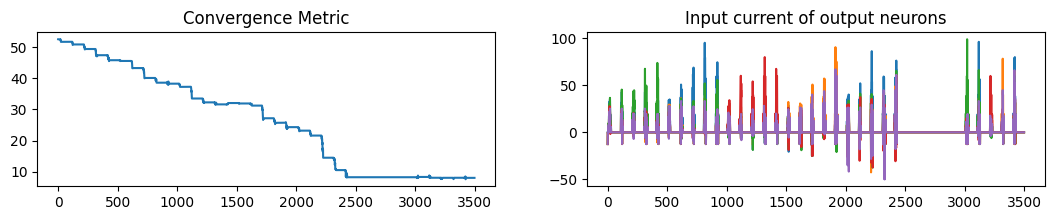

In [865]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, K, W_max = 15))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0][2:])
plt.title("Input current of output neurons")

plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_23748\1945826041.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)


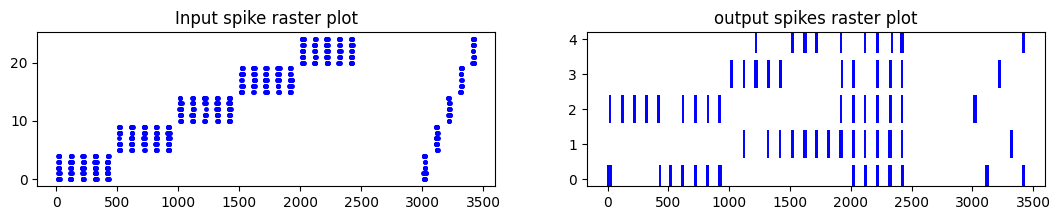

In [863]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(ng1['spikes.t', 0][K*N:], ng1['spikes.i', 0][K*N:], '.', color = "blue", markersize = 5)
plt.title("Input spike raster plot")

plt.subplot(1, 2, 2)
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue", marker = "|", markersize = 20, markeredgewidth=1.4)
plt.title("output spikes raster plot")
plt.yticks([i for i in range(K)])

plt.show()

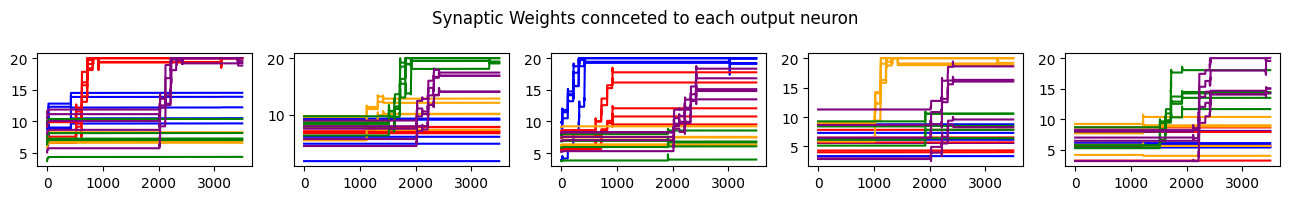

In [864]:
plt.figure(figsize = (13, 2))
colors = ['blue', 'red', 'orange', 'green', 'purple', "gray", "lightblue", "pink", "yellow", "black"]
for i in range(K) : 
    A = sg['weights', 0][:,:,i]
    for j in range(K) : 
        plt.subplot(1, 5, i + 1)
        plt.plot(A[:,(j*N):(j + 1)*N], color = colors[j], label = f"pattern {j + 1}")
    # plt.legend()
plt.suptitle(f"Synaptic Weights connceted to each output neuron")
plt.tight_layout()
plt.show()    

# Convergence Metric

In [27]:
def convergence_metric(sg, K, W_min = 0, W_max = 15) : 
    conv_rate = 0
    for i in range(K) : 
        conv_rate += torch.sum((W_max - sg['weights', 0][:,:,i])*(sg['weights', 0][:,:,i] - W_min), axis = 1) / 25
    
    conv_rate /= K
    return conv_rate
        

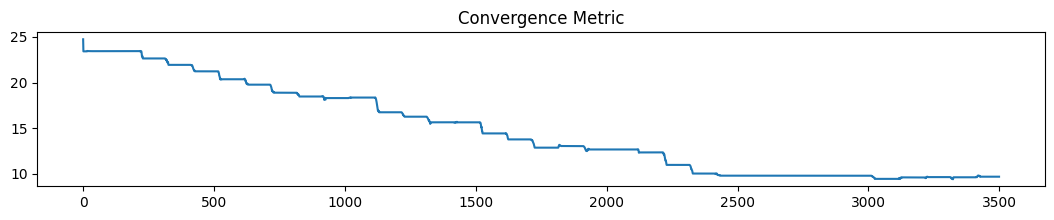

In [151]:
plt.figure(figsize = (13, 2))
plt.plot(convergence_metric(sg, K))
plt.title("Convergence Metric")
plt.show()

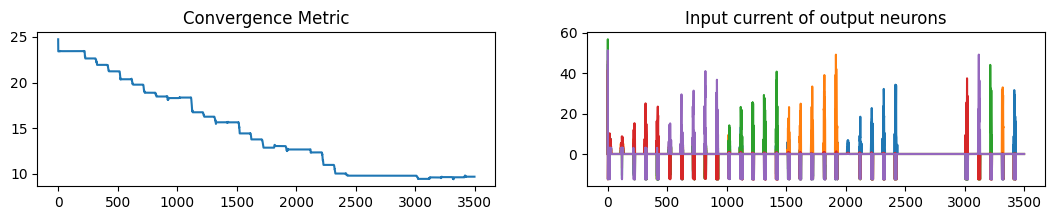

In [148]:
plt.figure(figsize = (13, 2))

plt.subplot(1, 2, 1)
plt.plot(convergence_metric(sg, K))
plt.title("Convergence Metric")

plt.subplot(1, 2, 2)
plt.plot(ng2['I', 0])
plt.title("Input current of output neurons")

plt.show()